In [ ]:
#!cp -r /content/drive/MyDrive/all_frames/ /content/all_frames/

In [ ]:
import cv2
import os
import io
import pandas as pd
import numpy as np
import zipfile
import tensorflow as tf

In [ ]:
zip_file_path = '/content/all_frames-20231017T204430Z-001.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Get a list of all the file names in the zip file
    image_filenames = zip_file.namelist()

    # Sort the filenames if needed
    image_filenames.sort()

    # Create an empty list to store the images
    images = []

    # Iterate through the image filenames in the zip file
    for filename in image_filenames:
        # Read the image from the zip file
        with zip_file.open(filename) as image_file:
            image_data = io.BytesIO(image_file.read())
            image = cv2.imdecode(np.frombuffer(image_data.read(), np.uint8), cv2.IMREAD_COLOR)
            images.append(image)


In [ ]:
import pickle

# Load landmarks_list from its .pkl file
with open('landmarks_list.pkl', 'rb') as file:
    landmarks_list = pickle.load(file)

# Load uncertainty_list from its .pkl file
with open('uncertainty_list.pkl', 'rb') as file:
    uncertainty_list = pickle.load(file)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = np.array(images)
y_coords = np.array(landmarks_list)
y_uncertainties = np.sqrt(np.array(uncertainty_list))  # Taking square root

# Reshape uncertainties to match the landmarks shape
y_uncertainties_reshaped = y_uncertainties.reshape(-1, 2)

# Scale the coordinates
scaler_coords = MinMaxScaler()
y_coords_scaled = scaler_coords.fit_transform(y_coords.reshape(-1, 2)).reshape(-1, 6, 2)

# Do not scale uncertainties; just reshape them
y_uncertainties_reshaped = y_uncertainties.reshape(-1, 6, 2)

# Combine the scaled coordinates and uncertainties
y_combined_scaled = np.hstack((y_coords_scaled, y_uncertainties_reshaped))
y_reshaped_scaled = y_combined_scaled.reshape(-1, 24)


In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
X = X.astype(np.float32)
X -= mean
X /= std

In [ ]:
y_combined_list = []

# Interlace coordinates and uncertainties for each sample
for i in range(len(y_coords_scaled)):
    interlaced_values = []
    for j in range(6):  # 6 landmarks
        interlaced_values.extend(y_coords_scaled[i][j])
        interlaced_values.extend(y_uncertainties_reshaped[i][j])
    y_combined_list.append(interlaced_values)

y_reshaped_scaled = np.array(y_combined_list)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X.shape, y_reshaped_scaled.shape

((17565, 112, 112, 3), (17565, 24))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_reshaped_scaled, test_size=0.2, random_state=42)

In [ ]:
print(y_train[0])

[ 0.44036697  0.24369748  6.          6.          0.44954128  0.68067227
  6.          6.          0.40366972  0.64705882  6.          6.
  0.63302752  0.65546218  6.          6.          0.39449541  0.55462185
  7.         13.          0.55963303  0.3697479   7.         13.        ]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Choose a random index
index = random.randint(0, len(X_train) - 1)

# Extract corresponding image and landmarks
img = X_train[index]
landmarks = y_train[index].reshape(6, 4)

# Plotting
fig, ax = plt.subplots(1)
ax.imshow(img * std + mean)  # De-normalizing the image for display

# Plot each landmark
for i in range(6):
    x, y, sigma_x, sigma_y = landmarks[i]
    ax.plot(x*112, y*112, 'ro')
    ellipse = patches.Ellipse((x*112, y*112), sigma_x*2, sigma_y*2, color='blue', fill=False)
    ax.add_patch(ellipse)

plt.show()

In [ ]:
!pip install --upgrade tensorflow

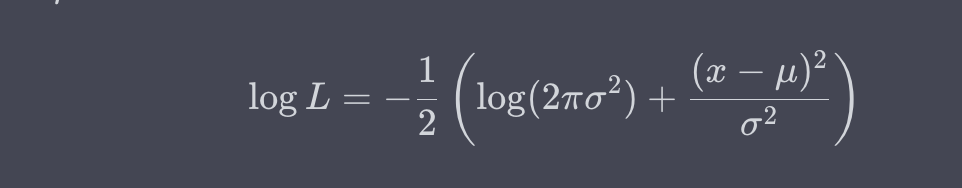

x punto real
u es la media de prediccion (predicted mean)
o es la desviacion (variancia en este caso)


In [ ]:
def modified_gaussian_likelihood(y_true, y_pred):
    """
    y_true: Tensor of true values. Shape (batch_size, 24).
    y_pred: Tensor of predicted values. Shape (batch_size, 24).
    """

    # Reshape the tensors to (batch_size, 6, 4)
    y_true = tf.reshape(y_true, (-1, 6, 4))
    y_pred = tf.reshape(y_pred, (-1, 6, 4))

    # Splitting the tensors into coordinates and uncertainties
    true_coords = y_true[:, :, :2]
    pred_coords = y_pred[:, :, :2]

    # Ensure that the predicted uncertainties are positive using softplus
    pred_uncertainties = tf.nn.softplus(y_pred[:, :, 2:])
    true_uncertainties = y_true[:, :, 2:]

    # Print intermediate values
    #tf.print("True Coords: ", tf.reduce_mean(true_coords), " Pred Coords: ", tf.reduce_mean(pred_coords))
    #tf.print("True Uncertainties: ", tf.reduce_mean(true_uncertainties), " Pred Uncertainties: ", tf.reduce_mean(pred_uncertainties))

    # Mean Squared Error for coordinates
    mse = tf.reduce_mean(tf.square(tf.cast(true_coords, tf.float32) - pred_coords), axis=-1)

    # Print MSE
    #tf.print("MSE: ", tf.reduce_mean(mse))

    # Gaussian Likelihood for uncertainties
    precision = 1 / tf.square(pred_uncertainties + 1e-6)  # Use square of standard deviations for precision
    mse_expanded = tf.expand_dims(mse, -1)
    log_likelihood = -0.5 * tf.reduce_sum(precision * mse_expanded + tf.math.log(tf.square(pred_uncertainties) + 1e-10), axis=-1)
    alpha = 4.0  # Weight for MSE
    beta = 0.1   # Weight for Log Likelihood
    print("Shape of mse:", mse.shape)
    print("Shape of log_likelihood:", log_likelihood.shape)

    # Weighted Loss
    loss = alpha * mse + beta * log_likelihood

    return tf.reduce_mean(loss)
    # Print log likelihood
    #tf.print("Log Likelihood: ", tf.reduce_mean(log_likelihood))

    #return tf.reduce_mean(log_likelihood)


In [ ]:
# Simulate a prediction by adding a small random noise to a random batch from y_train
random_indices = np.random.choice(y_train.shape[0], size=32, replace=False)  # select a batch of size 32
y_true_sample = y_train[random_indices]
y_pred_sample = y_true_sample + np.random.normal(0, 0.05, y_true_sample.shape)  # add small noise with reduced std deviation

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true_sample, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred_sample, dtype=tf.float32)

# Compute the loss
loss_value = modified_gaussian_likelihood(y_true_tensor, y_pred_tensor)
loss_value



Shape of mse: (32, 6)
Shape of log_likelihood: (32, 6)


<tf.Tensor: shape=(), dtype=float32, numpy=-0.38660565>

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_landmark_model(input_shape):
    # Load ResNet50 with ImageNet weights, excluding the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    biases = []
    for i in range(4):
        biases.extend([0.5, 0.5, 6, 6])
    biases.extend([0.5, 0.5, 7, 13, 0.5, 0.5, 7, 13])

    predictions = Dense(24, kernel_initializer='he_normal', bias_initializer=tf.keras.initializers.Constant(biases))(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss=modified_gaussian_likelihood)

    return model


In [ ]:
# Create the model
model = create_landmark_model((112, 112, 3))
#model.summary()

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)

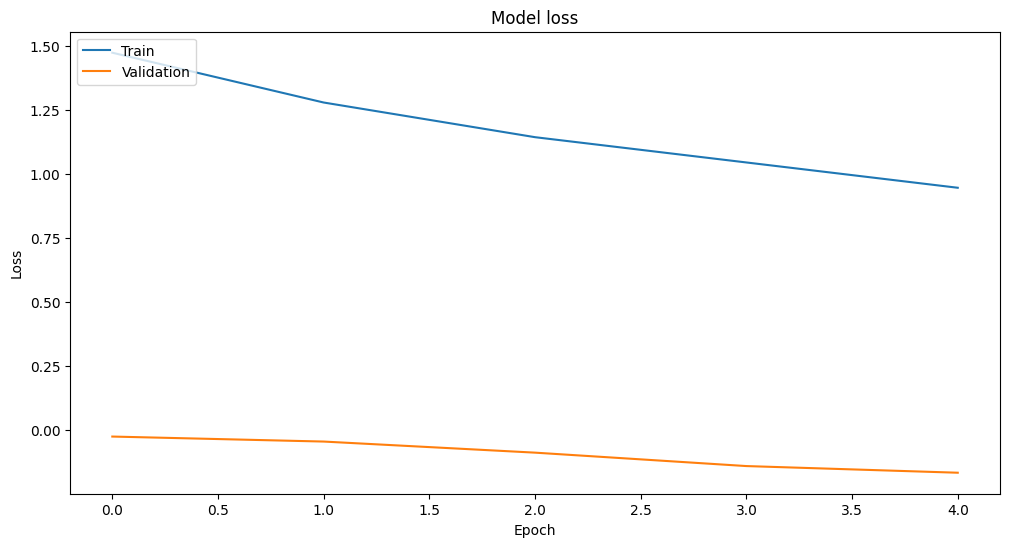

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Randomly select an image from the validation set
index = np.random.randint(0, len(X_val))
sample_image = X_val[index]
sample_true_coords = y_val[index].reshape(6, 4)[:,:2]  # Only coordinates
sample_true_uncertainties = y_val[index].reshape(6, 4)[:,2:]  # Only uncertainties

# Reshape the image for model prediction
input_image = np.expand_dims(sample_image, axis=0)

# Get model's predictions for this image
sample_pred = model.predict(input_image).reshape(6, 4)
sample_pred_coords = sample_pred[:,:2]
sample_pred_uncertainties = sample_pred[:,2:]

# Plot the image
plt.imshow(sample_image)
plt.axis('off')

# Plot true landmarks
for (x, y), (u, v) in zip(sample_true_coords, sample_true_uncertainties):
    plt.scatter([x*112], [y*112], color='blue', s=10)  # True coords
    ellipse = Ellipse((x*112, y*112), u, v, color='blue', fill=False)  # True uncertainties as ellipse
    plt.gca().add_patch(ellipse)

# Plot predicted landmarks
for (x, y), (u, v) in zip(sample_pred_coords, sample_pred_uncertainties):
    plt.scatter([x*112], [y*112], color='red', s=10)  # Predicted coords
    ellipse = Ellipse((x*112, y*112), u, v, color='red', fill=False)  # Predicted uncertainties as ellipse
    plt.gca().add_patch(ellipse)

plt.show()
